In [ ]:
import asb
import math
import torch
import pyprobound
import pyprobound.plotting
import pyprobound.utils
from matplotlib import pyplot as plt

# Data specification

In [ ]:
alphabet = pyprobound.alphabets.DNA()
dataframe = asb.get_asb_dataframe("CTCF.tsv")
asb_table = asb.ASBTable(
    dataframe, alphabet, left_flank_length=29, right_flank_length=29
)

# Model specification

In [ ]:
# PSAMs
nonspecific = pyprobound.layers.NonSpecific(alphabet=alphabet, name="NS")
psam = pyprobound.layers.PSAM(
    kernel_size=18,
    alphabet=alphabet,
    name="CTCF",
)
psam.reload("../likelihood/data/bindingModels/motifcentral_fit_12715.pt")

{'time': 'Tue Sep 26 11:40:26 2023',
 'version': '1.0.0',
 'flank_lengths': [(0, 0)]}

# Fitting

In [ ]:
lengths = []
losses = []
regs = []
rhos = []
for length in range(math.floor(psam.kernel_size / 2), 30):
    psam._layers.clear()
    psam.train_betas = False

    asb_table.set_flank_length(length, length)

    aggregate = asb.ASBAggregate(
        (
            pyprobound.Contribution(bmd)
            for bmd in [
                pyprobound.Mode(
                    [
                        pyprobound.layers.Conv0d.from_nonspecific(
                            nonspecific, asb_table
                        )
                    ]
                ),
                pyprobound.Mode(
                    [pyprobound.layers.Conv1d.from_psam(psam, asb_table)]
                ),
            ]
        ),
    )
    model = asb.ASBLoss([aggregate])
    optimizer = pyprobound.Optimizer(
        model,
        [asb_table],
        greedy_threshold=0,
        device="cpu",
        checkpoint="test_lengths.pt",
    )
    optimizer.train_sequential()
    with torch.inference_mode():
        loss, reg = model([asb_table])
        rho = torch.exp(aggregate.log_rho)
    lengths.append(length)
    losses.append(loss)
    regs.append(reg)
    rhos.append(rho)

### Regularization:
	 L1 Lambda: 0
	 L2 Lambda: 1e-06
	 Pseudocount: 0
	 Exponential Bound: 40
	 Excluded Reg.: frozenset()
	 Eq. Contribution: False
	 Weights: [1.0]

### Aggregates:
	Aggregate: 0thASBAggregate

### Binding Components:
	 Mode 0: (NSNonSpecific,)
		Found In
			0thASBAggregate→0thContribution
	 Mode 1: (CTCFPSAM,)
		Found In
			0thASBAggregate→1stContribution

### Tables:
	Table: 0
		Left Flank Length: 9
		Right Flank Length: 9

### Training Mode 0: NSNonSpecific
	ASBLoss → 0thASBAggregate → 0thASBAggregate→0thContribution → 0thASBAggregate→NSNonSpecificMode
	0.	ASBLoss.freeze()
		0thASBAggregate.activity_heuristic(contribution=0thASBAggregate→0thContribution)
	1.	ASBLoss.unfreeze(parameter=all)
				aggregates.0.log_target_concentration grad=False 0.0
				aggregates.0.log_rho grad=True -1.0
				aggregates.0.contributions.0.log_activity grad=True -2.944438934326172
				aggregates.0.contributions.0.binding.log_hill grad=False 0.0
				aggregates.0.contributions.0.binding.l

/Users/lucas/Optimer/Gits/PyProBound/src/pyprobound/optimizer.py:142: UserWarning: Checkpoint file test_lengths.pt is not empty
  warnings.warn(f"Checkpoint file {checkpoint} is not empty")


			Loss decreased
			Epoch 0 took 0.89s NLL: 3.2259762287 Reg.: 0.0002824283 Distance: 5.8733305931 Patience: 10
			Epoch 1 took 0.32s NLL: 3.2259762287 Reg.: 0.0002824283 Distance: 0.0000000000 Patience: 9
				aggregates.0.log_target_concentration grad=False 0.0
				aggregates.0.log_rho grad=True -2.338439702987671
				aggregates.0.contributions.0.log_activity grad=True 1.0562124252319336
				aggregates.0.contributions.0.binding.log_hill grad=False 0.0
				aggregates.0.contributions.0.binding.layers.0.log_posbias grad=False tensor([[[0.]]])
				aggregates.0.contributions.1.log_activity grad=True 10.685208320617676
				aggregates.0.contributions.1.binding.log_hill grad=False 0.0
				aggregates.0.contributions.1.binding.layers.0.log_posbias grad=False
					tensor([[[0., 0., 0., 0.],
			                 [0., 0., 0., 0.]]])
				aggregates.0.contributions.1.binding.layers.0.layer_spec.bias grad=False tensor([[0.]])
				aggregates.0.contributions.1.binding.layers.0.layer_spec.betas-monomer 

# Plotting

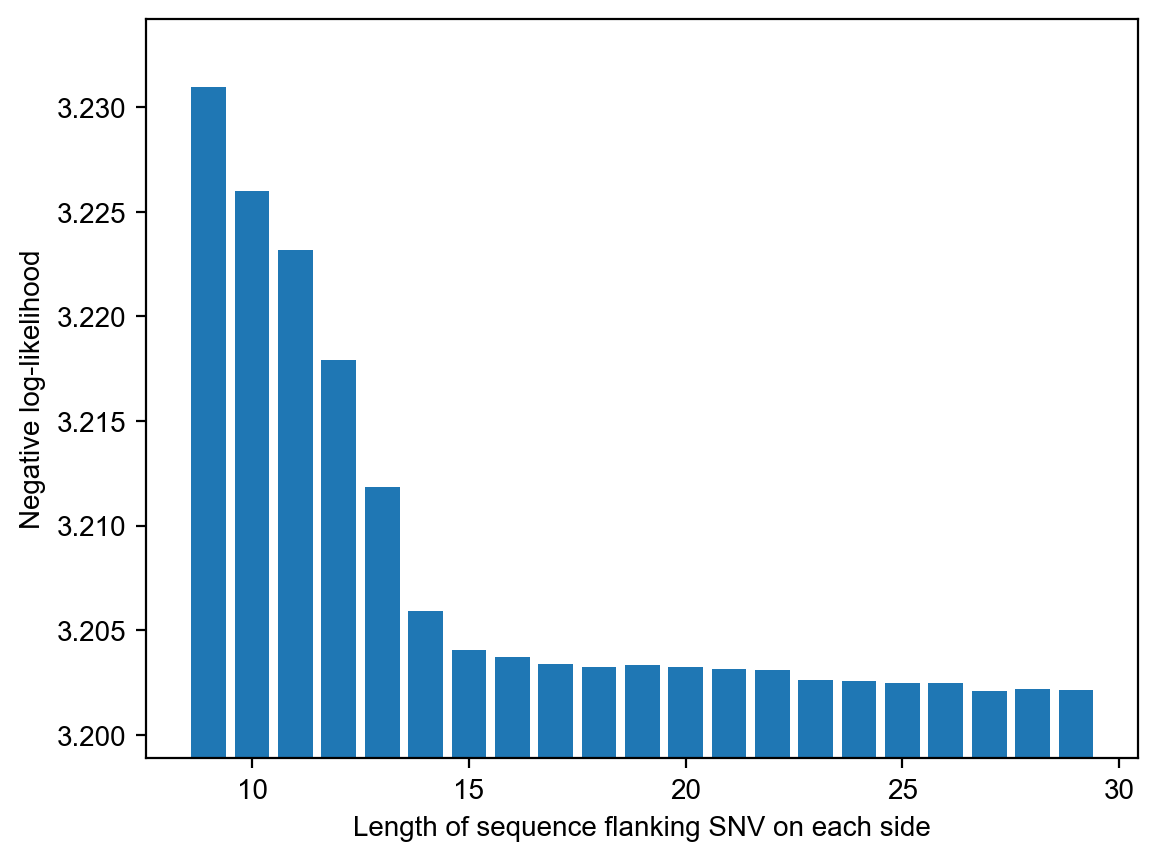

In [ ]:
plt.bar(lengths, losses)
plt.ylim((0.999 * min(losses), 1.001 * max(losses)))
plt.ylabel("Negative log-likelihood")
plt.xlabel("Length of sequence flanking SNV on each side")
plt.show()